In [1]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Model
from keras.applications import DenseNet121
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

In [2]:
path = '../data/'
dataset_path = pathlib.Path(path)
images = os.listdir(dataset_path)

In [5]:
df = pd.read_csv(path + "small-new.csv")
df = df.reset_index(drop=True)
print(df.shape)
df.head(5)

(60, 11)


,Unnamed: 0,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,4,25520,Girls,Apparel,Topwear,Tops,White,Casual,Doodle Kids Girls City Chic White Top,25520.jpg,http://assets.myntassets.com/v1/images/style/p...


In [6]:
df.drop(['Unnamed: 0'], axis=1)
df.to_csv('../data/small-new.csv')

In [7]:
from keras.losses import cosine_similarity, mse

def triplet_loss(y_true, y_pred, margin=0.2):
    anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]
    positive_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    return loss

In [8]:
img_width, img_height, chnl = 200, 200, 3

densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = False

model = keras.Sequential([
    densenet,
    GlobalMaxPooling2D()
])

model.compile(optimizer='adam', loss=triplet_loss)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 7037504 (26.85 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [9]:
def img_path(img):
    return path + 'images/' + img

def model_predict(model, img_name):
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [10]:
df_copy = df
df_embedding = df_copy['Image'].apply(lambda x: model_predict(model, x))
df_embedding = df_embedding.apply(pd.Series)
df_embedding.head(5)
df_embedding.to_csv('embeddings_data_new.csv', index=False)

1/1 [==============================] - 0s 88ms/step


C:\Users\puran\AppData\Local\Temp\ipykernel_6296\3004232465.py:3: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df_embedding = df_embedding.apply(pd.Series)


In [11]:
cosine_sim = linear_kernel(df_embedding, df_embedding)
indices = pd.Series(range(len(df)), index=df.index)

In [16]:
def get_recommendations(index, df, cosine_sim=cosine_sim):
    print('Enter')
    idx = indices[index]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    cloth_indices = [i[0] for i in sim_scores]
    print('Exit')
    return df['Image'].iloc[cloth_indices]


Enter
Exit


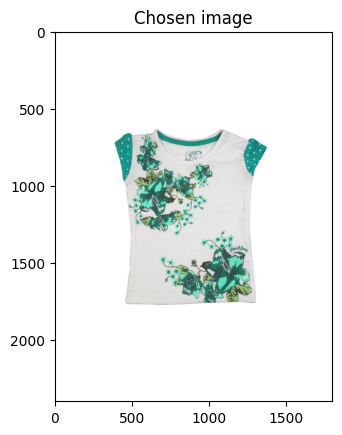

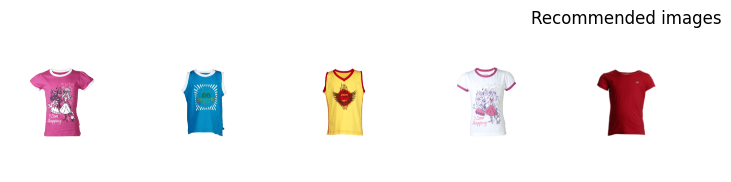

In [20]:
chosen_image_index = 0

recommendation = get_recommendations(chosen_image_index, df, cosine_sim)
recommendation_list = recommendation.to_list()
chosen_img = mpimg.imread(path + 'images/' + df.iloc[chosen_image_index].Image)
plt.title("Chosen image")
plt.imshow(chosen_img)

plt.figure(figsize=(20, 20))
j = 0
for i in recommendation_list:
    plt.subplot(6, 10, j + 1)
    cloth_img = mpimg.imread(path + 'images/' + i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j += 1
plt.title("Recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [21]:
model_json = model.to_json()
with open("model_architecture-new.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights-new.h5")

print("Model architecture and weights saved successfully.")

Model architecture and weights saved successfully.
